### imports

# Introduction 
This is my effort to do a *minimum* `Keras` replication with comparable baseline to the great kernel of @mhiro2 https://www.kaggle.com/mhiro2/simple-2d-cnn-classifier-with-pytorch (and further improved by @peining), which in turns use the excellent pre-processed data of @daisukelab https://www.kaggle.com/daisukelab/creating-fat2019-preprocessed-data) -- Note that to inference to the private data in stage-2, you have to preprocess data yourself.

One change I made in a Keras version, instead of a simple conv net, I decide to use a pre-defined architectures [trained from scratch] `MobileNetV2`, `InceptionV3` and `Xception` where you can choose in the kernel. Also, many ideas borrow from a nice kernel of @voglinio https://www.kaggle.com/voglinio/keras-2d-model-5-fold-log-specgram-curated-only , I also borrow the SoftMax+BCE loss & TTA ideas from Giba's kernel (BTW, we all know Giba without having to mention his user :).

**UPDATE in V.17 : I add a simple CNN almost exactly the same as the pytorch baseline**

I apologize that my code is not at all clean; some of the `pytorch` code is still here albeit not used.

## Major Updates
* V1 [CV680, LB574]
* V4 [CV66x, LB576]
* V5 [] Add image augmentation module
* V9 [CV679] Add lwlrap TF metric (credit @rio114 : https://www.kaggle.com/rio114/keras-cnn-with-lwlrap-evaluation )
* V11 [] Employ list of augmentations mentioned in https://github.com/sainathadapa/kaggle-freesound-audio-tagging/blob/master/approaches_all.md
* V16 [] Add BCEwithLogits (use only with ACTIVATION = 'linear')
* V17 add SimpleCNN similar to the pytorch baseline
* V20 add Curated-Only, Train-augment options


**with BCEwithLogits and SimpleCNN, now this kernel should almost comparable to the pytorch baseline**

### Minor Updates
* V15[CV662]


In [3]:
import gc
import os
import pickle
import random
import time
from collections import Counter, defaultdict
from functools import partial
from pathlib import Path
from psutil import cpu_count
import matplotlib.pyplot as plt

import librosa
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
#from skmultilearn.model_selection import iterative_train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from fastprogress import master_bar, progress_bar
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

### utils

In [4]:
NUM_CLASSES = 80
checkpoint_file = 'model_best.h5'
SIZE=128
EPOCHS = 200 #150 for inception, 100 for xception
BATCH_SIZE = 64

LR = 4e-4
TTA = 19 #Number of test-time augmentation
PATIENCE = 5  #ReduceOnPlateau option
LR_FACTOR = 0.25 #ReduceOnPlateau option
CURATED_ONLY = True # use only curated data for training
TRAIN_AUGMENT = True # use augmentation for training data?
MODEL = 'inception' # choose among 'xception', 'inception', 'mobile', 'simple'

# if use BCEwithLogits loss, use Activation = 'linear' only
ACTIVATION = 'linear' 
# ACTIVATION = 'softmax'
# ACTIVATION = 'sigmoid'

# LOSS = 'categorical_crossentropy'
# LOSS = 'binary_crossentropy' 
LOSS = 'BCEwithLogits' 

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 520
seed_everything(SEED)

In [6]:
# from official code https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8#scrollTo=cRCaCIb9oguU
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class

In [7]:
import tensorflow as tf

# from https://www.kaggle.com/ratthachat/keras-cnn-with-lwlrap-evaluation/edit
def tf_one_sample_positive_class_precisions(y_true, y_pred) :
    num_samples, num_classes = y_pred.shape
    
    # find true labels
    pos_class_indices = tf.where(y_true > 0) 
    
    # put rank on each element
    retrieved_classes = tf.nn.top_k(y_pred, k=num_classes).indices
    sample_range = tf.zeros(shape=tf.shape(tf.transpose(y_pred)), dtype=tf.int32)
    sample_range = tf.add(sample_range, tf.range(tf.shape(y_pred)[0], delta=1))
    sample_range = tf.transpose(sample_range)
    sample_range = tf.reshape(sample_range, (-1,num_classes*tf.shape(y_pred)[0]))
    retrieved_classes = tf.reshape(retrieved_classes, (-1,num_classes*tf.shape(y_pred)[0]))
    retrieved_class_map = tf.concat((sample_range, retrieved_classes), axis=0)
    retrieved_class_map = tf.transpose(retrieved_class_map)
    retrieved_class_map = tf.reshape(retrieved_class_map, (tf.shape(y_pred)[0], num_classes, 2))
    
    class_range = tf.zeros(shape=tf.shape(y_pred), dtype=tf.int32)
    class_range = tf.add(class_range, tf.range(num_classes, delta=1))
    
    class_rankings = tf.scatter_nd(retrieved_class_map,
                                          class_range,
                                          tf.shape(y_pred))
    
    #pick_up ranks
    num_correct_until_correct = tf.gather_nd(class_rankings, pos_class_indices)

    # add one for division for "presicion_at_hits"
    num_correct_until_correct_one = tf.add(num_correct_until_correct, 1) 
    num_correct_until_correct_one = tf.cast(num_correct_until_correct_one, tf.float32)
    
    # generate tensor [num_sample, predict_rank], 
    # top-N predicted elements have flag, N is the number of positive for each sample.
    sample_label = pos_class_indices[:, 0]   
    sample_label = tf.reshape(sample_label, (-1, 1))
    sample_label = tf.cast(sample_label, tf.int32)
    
    num_correct_until_correct = tf.reshape(num_correct_until_correct, (-1, 1))
    retrieved_class_true_position = tf.concat((sample_label, 
                                               num_correct_until_correct), axis=1)
    retrieved_pos = tf.ones(shape=tf.shape(retrieved_class_true_position)[0], dtype=tf.int32)
    retrieved_class_true = tf.scatter_nd(retrieved_class_true_position, 
                                         retrieved_pos, 
                                         tf.shape(y_pred))
    # cumulate predict_rank
    retrieved_cumulative_hits = tf.cumsum(retrieved_class_true, axis=1)

    # find positive position
    pos_ret_indices = tf.where(retrieved_class_true > 0)

    # find cumulative hits
    correct_rank = tf.gather_nd(retrieved_cumulative_hits, pos_ret_indices)  
    correct_rank = tf.cast(correct_rank, tf.float32)

    # compute presicion
    precision_at_hits = tf.truediv(correct_rank, num_correct_until_correct_one)

    return pos_class_indices, precision_at_hits

def tf_lwlrap(y_true, y_pred):
    num_samples, num_classes = y_pred.shape
    pos_class_indices, precision_at_hits = (tf_one_sample_positive_class_precisions(y_true, y_pred))
    pos_flgs = tf.cast(y_true > 0, tf.int32)
    labels_per_class = tf.reduce_sum(pos_flgs, axis=0)
    weight_per_class = tf.truediv(tf.cast(labels_per_class, tf.float32),
                                  tf.cast(tf.reduce_sum(labels_per_class), tf.float32))
    sum_precisions_by_classes = tf.zeros(shape=(num_classes), dtype=tf.float32)  
    class_label = pos_class_indices[:,1]
    sum_precisions_by_classes = tf.unsorted_segment_sum(precision_at_hits,
                                                        class_label,
                                                       num_classes)
    labels_per_class = tf.cast(labels_per_class, tf.float32)
    labels_per_class = tf.add(labels_per_class, 1e-7)
    per_class_lwlrap = tf.truediv(sum_precisions_by_classes,
                                  tf.cast(labels_per_class, tf.float32))
    out = tf.cast(tf.tensordot(per_class_lwlrap, weight_per_class, axes=1), dtype=tf.float32)
    return out

In [8]:
from keras import backend as k
def BCEwithLogits(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_true, y_pred, from_logits=True), axis=-1)

Using TensorFlow backend.


### dataset

In [9]:
dataset_dir = Path('../input/freesound-audio-tagging-2019')
preprocessed_dir = Path('../input/fat2019_prep_mels1')

In [10]:
csvs = {
    'train_curated': dataset_dir / 'train_curated.csv',
    #'train_noisy': dataset_dir / 'train_noisy.csv',
    'train_noisy': preprocessed_dir / 'trn_noisy_best50s.csv',
    'sample_submission': dataset_dir / 'sample_submission.csv',
}

dataset = {
    'train_curated': dataset_dir / 'train_curated',
    'train_noisy': dataset_dir / 'train_noisy',
    'test': dataset_dir / 'test',
}

mels = {
    'train_curated': preprocessed_dir / 'mels_train_curated.pkl',
    'train_noisy': preprocessed_dir / 'mels_trn_noisy_best50s.pkl',
    'test': preprocessed_dir / 'mels_test.pkl',  # NOTE: this data doesn't work at 2nd stage
}

In [11]:
train_curated = pd.read_csv(csvs['train_curated'])
train_noisy = pd.read_csv(csvs['train_noisy'])
if CURATED_ONLY:
    train_df = train_curated
else:
    train_df = pd.concat([train_curated, train_noisy], sort=True, ignore_index=True)
train_df.head()

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping


In [12]:
test_df = pd.read_csv(csvs['sample_submission'])
test_df.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,Bus,Buzz,Car_passing_by,Cheering,Chewing_and_mastication,Child_speech_and_kid_speaking,Chink_and_clink,Chirp_and_tweet,Church_bell,Clapping,Computer_keyboard,Crackle,Cricket,Crowd,Cupboard_open_or_close,Cutlery_and_silverware,Dishes_and_pots_and_pans,Drawer_open_or_close,Drip,Electric_guitar,Fart,Female_singing,Female_speech_and_woman_speaking,Fill_(with_liquid),Finger_snapping,Frying_(food),Gasp,Glockenspiel,Gong,...,Harmonica,Hi-hat,Hiss,Keys_jangling,Knock,Male_singing,Male_speech_and_man_speaking,Marimba_and_xylophone,Mechanical_fan,Meow,Microwave_oven,Motorcycle,Printer,Purr,Race_car_and_auto_racing,Raindrop,Run,Scissors,Screaming,Shatter,Sigh,Sink_(filling_or_washing),Skateboard,Slam,Sneeze,Squeak,Stream,Strum,Tap,Tick-tock,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,000ccb97.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0012633b.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,001ed5f1.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00294be0.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,003fde7a.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
labels = test_df.columns[1:].tolist()
labels[:10]

['Accelerating_and_revving_and_vroom',
 'Accordion',
 'Acoustic_guitar',
 'Applause',
 'Bark',
 'Bass_drum',
 'Bass_guitar',
 'Bathtub_(filling_or_washing)',
 'Bicycle_bell',
 'Burping_and_eructation']

In [14]:
num_classes = len(labels)
num_classes

80

In [15]:
y_train = np.zeros((len(train_df), num_classes)).astype(int)
for i, row in enumerate(train_df['labels'].str.split(',')):
    for label in row:
        idx = labels.index(label)
        y_train[i, idx] = 1

y_train.shape

(4970, 80)

In [16]:
with open(mels['train_curated'], 'rb') as curated, open(mels['train_noisy'], 'rb') as noisy:
    x_train = pickle.load(curated)
    if CURATED_ONLY == False:
        x_train.extend(pickle.load(noisy))

with open(mels['test'], 'rb') as test:
    x_test = pickle.load(test)
    
len(x_train), len(x_test)

(4970, 1120)

In [17]:

for ii in range(5):
    print(x_train[ii].shape) #x_train is of shape (TRAIN_NUM,128,LEN,3) [4D Tensor]
    print(x_test[ii].shape,'\n')  #x_test of shape (TEST_NUM,128,LEN,3) [4D Tensor]

(128, 448, 3)
(128, 128, 3) 

(128, 131, 3)
(128, 1021, 3) 

(128, 128, 3)
(128, 300, 3) 

(128, 1623, 3)
(128, 1146, 3) 

(128, 128, 3)
(128, 1442, 3) 



### model

In [18]:
from keras.layers import *
from keras.models import Sequential, load_model, Model
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_inception
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobile
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as preprocess_xception

from keras.utils import Sequence
from sklearn.utils import shuffle
def create_model_inception(n_out=NUM_CLASSES):

    base_model =InceptionV3(weights=None, include_top=False)
    
    x0 = base_model.output
    x1 = GlobalAveragePooling2D()(x0)
    x2 = GlobalMaxPooling2D()(x0)
    x = Concatenate()([x1,x2])
    
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    
    predictions = Dense(n_out, activation=ACTIVATION)(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [19]:
def create_model_xception(n_out=NUM_CLASSES):

    base_model = Xception(weights=None, include_top=False)
    
    x0 = base_model.output
    x1 = GlobalAveragePooling2D()(x0)
    x2 = GlobalMaxPooling2D()(x0)
    x = Concatenate()([x1,x2])
    
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

#     x = Dense(128, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.3)(x)
    
    predictions = Dense(n_out, activation=ACTIVATION)(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [20]:
def create_model_mobile(n_out=NUM_CLASSES):

    base_model =MobileNetV2(weights=None, include_top=False)
    
    x0 = base_model.output
    x1 = GlobalAveragePooling2D()(x0)
    x2 = GlobalMaxPooling2D()(x0)
    x = Concatenate()([x1,x2])
    
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

#     x = Dense(128, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.25)(x)

    
    predictions = Dense(n_out, activation=ACTIVATION)(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [21]:
def conv_simple_block(x, n_filters):
    
    x = Convolution2D(n_filters, (3,1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Convolution2D(n_filters, (3,1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = AveragePooling2D()(x)

    return x

def create_model_simplecnn(n_out=NUM_CLASSES):
    
    inp = Input(shape=(128,128,3))
#     inp = Input(shape=(None,None,3))
    x = conv_simple_block(inp,64)
    x = conv_simple_block(x,128)
    x = conv_simple_block(x,256)
    x = conv_simple_block(x,512)
    
    x1 = GlobalAveragePooling2D()(x)
    x2 = GlobalMaxPooling2D()(x)
    x = Add()([x1,x2])

    x = Dropout(0.2)(x)

    x = Dense(128, activation='linear')(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    predictions = Dense(n_out, activation=ACTIVATION)(x)

    model = Model(inputs=inp, outputs=predictions)
    return model

In [22]:
'''Choose your model here'''
if MODEL == 'xception':
    preprocess_input = preprocess_xception
    model = create_model_xception(n_out=NUM_CLASSES)
if MODEL == 'inception':
    preprocess_input = preprocess_inception
    model = create_model_inception(n_out=NUM_CLASSES)
if MODEL == 'mobile':
    preprocess_input = preprocess_mobile
    model = create_model_mobile(n_out=NUM_CLASSES)
else:
    preprocess_input = preprocess_mobile
    model = create_model_simplecnn(
    n_out=NUM_CLASSES)

print(MODEL)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
inception
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 128, 128, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_97 (BatchNo (None, 128, 128, 64) 256         conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_

### train

In [23]:
# If you want, you can try more advanced augmentation like this
augment_img = iaa.Sequential([
    iaa.SomeOf((0,3),[
#         iaa.ContrastNormalization((0.9, 1.1)),
#         iaa.Multiply((0.9, 1.1), per_channel=0.2),
        iaa.Fliplr(0.5),
        iaa.GaussianBlur(sigma=(0, 0.1)),
        iaa.Affine( # x-shift
            translate_percent={"x": (-0.1, 0.1), "y": (-0.0, 0.0)},
        ),
        iaa.CoarseDropout(0.1,size_percent=0.05) # see examples : https://github.com/aleju/imgaug
            ])], random_order=True)


# Or you can choose this simplest augmentation (like pytorch version)
# augment_img = iaa.Fliplr(0.5)

# This is my ugly modification; sorry about that
class FATTrainDataset(Sequence):

    def getitem(image):
        # crop 2sec

        base_dim, time_dim, _ = image.shape
        crop = random.randint(0, time_dim - base_dim)
        image = image[:,crop:crop+base_dim,:]

        image = preprocess_input(image)
        
#         label = self.labels[idx]
        return image
    def create_generator(train_X, train_y, batch_size, shape, augument=False, shuffling=False, test_data=False):
        assert shape[2] == 3
        while True:
            if shuffling:
                train_X,train_y = shuffle(train_X,train_y)

            for start in range(0, len(train_y), batch_size):
                end = min(start + batch_size, len(train_y))
                batch_images = []
                X_train_batch = train_X[start:end]
                if test_data == False:
                    batch_labels = train_y[start:end]
                
                for i in range(len(X_train_batch)):
                    image = FATTrainDataset.getitem(X_train_batch[i])   
                    if augument:
                        image = FATTrainDataset.augment(image)
                    batch_images.append(image)
                    
                if test_data == False:
                    yield np.array(batch_images, np.float32), batch_labels
                else:
                    yield np.array(batch_images, np.float32)
        return image
    
    def augment(image):

        image_aug = augment_img.augment_image(image)
        return image_aug

In [24]:
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)
                             
from sklearn.model_selection import train_test_split

checkpoint = ModelCheckpoint(checkpoint_file, monitor='val_tf_lwlrap', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = False)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_tf_lwlrap', factor=LR_FACTOR, patience=PATIENCE, 
                                   verbose=1, mode='max', min_delta=0.0001, cooldown=2, min_lr=1e-5 )

csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)


# split data into train, valid
x_trn, x_val, y_trn, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=SEED)

# create train and valid datagens
train_generator = FATTrainDataset.create_generator(
    x_trn, y_trn, BATCH_SIZE, (SIZE,SIZE,3), augument=TRAIN_AUGMENT, shuffling=True)
validation_generator = FATTrainDataset.create_generator(
    x_val, y_val, BATCH_SIZE, (SIZE,SIZE,3), augument=False, shuffling=False)

callbacks_list = [checkpoint, csv_logger, reduceLROnPlat]

In [25]:
train_steps = np.ceil(float(len(x_trn)) / float(BATCH_SIZE))
val_steps = np.ceil(float(len(x_val)) / float(BATCH_SIZE))
train_steps = train_steps.astype(int)
val_steps = val_steps.astype(int)
print(train_steps, val_steps)
print(len(x_trn), BATCH_SIZE)


63 16
3976 64


In [26]:
print(LOSS)
if LOSS=='BCEwithLogits':
     model.compile(loss=BCEwithLogits,
            optimizer=Adam(lr=LR),
            metrics=[tf_lwlrap,'categorical_accuracy'])
else:
    model.compile(loss=LOSS,
            optimizer=Adam(lr=LR),
            metrics=[tf_lwlrap,'categorical_accuracy'])


BCEwithLogits


In [27]:


hist = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/200
63/63 [==============================] - 20s 318ms/step - loss: 0.7227 - tf_lwlrap: 0.0862 - categorical_accuracy: 0.0164 - val_loss: 0.6846 - val_tf_lwlrap: 0.0919 - val_categorical_accuracy: 0.0191

Epoch 00001: val_tf_lwlrap improved from -inf to 0.09194, saving model to model_best.h5
Epoch 2/200
63/63 [==============================] - 10s 165ms/step - loss: 0.6515 - tf_lwlrap: 0.0966 - categorical_accuracy: 0.0203 - val_loss: 0.6204 - val_tf_lwlrap: 0.1267 - val_categorical_accuracy: 0.0412

Epoch 00002: val_tf_lwlrap improved from 0.09194 to 0.12671, saving model to model_best.h5
Epoch 3/200
63/63 [==============================] - 10s 164ms/step - loss: 0.5416 - tf_lwlrap: 0.0953 - categorical_accuracy: 0.0241 - val_loss: 0.3723 - val_tf_lwlrap: 0.0844 - val_categorical_accuracy: 0.0211

Epoch 00003: val_tf_lwlrap did not improve from 0.12671



Epoch 00027: val_tf_lwlrap did not improve from 0.54471
Epoch 28/200
63/63 [==============================] - 10s 164ms/step - loss: 0.0471 - tf_lwlrap: 0.6171 - categorical_accuracy: 0.4187 - val_loss: 0.0497 - val_tf_lwlrap: 0.5489 - val_categorical_accuracy: 0.3903

Epoch 00028: val_tf_lwlrap improved from 0.54471 to 0.54891, saving model to model_best.h5
Epoch 29/200
63/63 [==============================] - 10s 165ms/step - loss: 0.0457 - tf_lwlrap: 0.6349 - categorical_accuracy: 0.4329 - val_loss: 0.0467 - val_tf_lwlrap: 0.5736 - val_categorical_accuracy: 0.4014

Epoch 00029: val_tf_lwlrap improved from 0.54891 to 0.57356, saving model to model_best.h5
Epoch 30/200
63/63 [==============================] - 10s 164ms/step - loss: 0.0450 - tf_lwlrap: 0.6409 - categorical_accuracy: 0.4410 - val_loss: 0.0479 - val_tf_lwlrap: 0.5626 - val_categorical_accuracy: 0.3944

Epoch 00030: val_tf_lwlrap did not improve from 0.57356
Epoch 31/200
63/63 [==============================] - 10s 164ms

63/63 [==============================] - 10s 165ms/step - loss: 0.0290 - tf_lwlrap: 0.8312 - categorical_accuracy: 0.6625 - val_loss: 0.0340 - val_tf_lwlrap: 0.7267 - val_categorical_accuracy: 0.5684

Epoch 00056: val_tf_lwlrap did not improve from 0.74523
Epoch 57/200
63/63 [==============================] - 10s 165ms/step - loss: 0.0289 - tf_lwlrap: 0.8352 - categorical_accuracy: 0.6637 - val_loss: 0.0326 - val_tf_lwlrap: 0.7430 - val_categorical_accuracy: 0.5926

Epoch 00057: val_tf_lwlrap did not improve from 0.74523

Epoch 00057: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 58/200
63/63 [==============================] - 10s 164ms/step - loss: 0.0278 - tf_lwlrap: 0.8441 - categorical_accuracy: 0.6706 - val_loss: 0.0322 - val_tf_lwlrap: 0.7473 - val_categorical_accuracy: 0.5936

Epoch 00058: val_tf_lwlrap improved from 0.74523 to 0.74735, saving model to model_best.h5
Epoch 59/200
63/63 [==============================] - 10s 165ms/step - loss: 0.0280 - t

63/63 [==============================] - 10s 165ms/step - loss: 0.0260 - tf_lwlrap: 0.8647 - categorical_accuracy: 0.6999 - val_loss: 0.0314 - val_tf_lwlrap: 0.7535 - val_categorical_accuracy: 0.5976

Epoch 00085: val_tf_lwlrap did not improve from 0.76150
Epoch 86/200
63/63 [==============================] - 10s 164ms/step - loss: 0.0260 - tf_lwlrap: 0.8648 - categorical_accuracy: 0.6964 - val_loss: 0.0315 - val_tf_lwlrap: 0.7491 - val_categorical_accuracy: 0.5895

Epoch 00086: val_tf_lwlrap did not improve from 0.76150
Epoch 87/200
63/63 [==============================] - 10s 165ms/step - loss: 0.0258 - tf_lwlrap: 0.8599 - categorical_accuracy: 0.6947 - val_loss: 0.0314 - val_tf_lwlrap: 0.7514 - val_categorical_accuracy: 0.5915

Epoch 00087: val_tf_lwlrap did not improve from 0.76150
Epoch 88/200
63/63 [==============================] - 10s 163ms/step - loss: 0.0254 - tf_lwlrap: 0.8731 - categorical_accuracy: 0.7054 - val_loss: 0.0307 - val_tf_lwlrap: 0.7690 - val_categorical_accurac

63/63 [==============================] - 10s 166ms/step - loss: 0.0251 - tf_lwlrap: 0.8765 - categorical_accuracy: 0.7141 - val_loss: 0.0311 - val_tf_lwlrap: 0.7543 - val_categorical_accuracy: 0.6026

Epoch 00115: val_tf_lwlrap did not improve from 0.76896
Epoch 116/200
63/63 [==============================] - 10s 163ms/step - loss: 0.0248 - tf_lwlrap: 0.8789 - categorical_accuracy: 0.7141 - val_loss: 0.0308 - val_tf_lwlrap: 0.7632 - val_categorical_accuracy: 0.6026

Epoch 00116: val_tf_lwlrap did not improve from 0.76896
Epoch 117/200
63/63 [==============================] - 10s 163ms/step - loss: 0.0252 - tf_lwlrap: 0.8708 - categorical_accuracy: 0.7109 - val_loss: 0.0306 - val_tf_lwlrap: 0.7620 - val_categorical_accuracy: 0.6066

Epoch 00117: val_tf_lwlrap did not improve from 0.76896
Epoch 118/200
63/63 [==============================] - 10s 163ms/step - loss: 0.0248 - tf_lwlrap: 0.8782 - categorical_accuracy: 0.7126 - val_loss: 0.0314 - val_tf_lwlrap: 0.7499 - val_categorical_accu

63/63 [==============================] - 10s 166ms/step - loss: 0.0242 - tf_lwlrap: 0.8856 - categorical_accuracy: 0.7234 - val_loss: 0.0307 - val_tf_lwlrap: 0.7613 - val_categorical_accuracy: 0.6127

Epoch 00145: val_tf_lwlrap did not improve from 0.76896
Epoch 146/200
63/63 [==============================] - 11s 170ms/step - loss: 0.0241 - tf_lwlrap: 0.8797 - categorical_accuracy: 0.7203 - val_loss: 0.0307 - val_tf_lwlrap: 0.7634 - val_categorical_accuracy: 0.6127

Epoch 00146: val_tf_lwlrap did not improve from 0.76896
Epoch 147/200
63/63 [==============================] - 10s 164ms/step - loss: 0.0241 - tf_lwlrap: 0.8851 - categorical_accuracy: 0.7287 - val_loss: 0.0311 - val_tf_lwlrap: 0.7472 - val_categorical_accuracy: 0.5926

Epoch 00147: val_tf_lwlrap did not improve from 0.76896
Epoch 148/200
63/63 [==============================] - 10s 164ms/step - loss: 0.0240 - tf_lwlrap: 0.8869 - categorical_accuracy: 0.7304 - val_loss: 0.0307 - val_tf_lwlrap: 0.7570 - val_categorical_accu

63/63 [==============================] - 10s 166ms/step - loss: 0.0233 - tf_lwlrap: 0.8971 - categorical_accuracy: 0.7324 - val_loss: 0.0298 - val_tf_lwlrap: 0.7671 - val_categorical_accuracy: 0.6097

Epoch 00175: val_tf_lwlrap did not improve from 0.77441
Epoch 176/200
63/63 [==============================] - 10s 164ms/step - loss: 0.0235 - tf_lwlrap: 0.8892 - categorical_accuracy: 0.7300 - val_loss: 0.0299 - val_tf_lwlrap: 0.7732 - val_categorical_accuracy: 0.6177

Epoch 00176: val_tf_lwlrap did not improve from 0.77441
Epoch 177/200
63/63 [==============================] - 10s 164ms/step - loss: 0.0234 - tf_lwlrap: 0.8887 - categorical_accuracy: 0.7361 - val_loss: 0.0302 - val_tf_lwlrap: 0.7576 - val_categorical_accuracy: 0.5976

Epoch 00177: val_tf_lwlrap did not improve from 0.77441
Epoch 178/200
63/63 [==============================] - 10s 162ms/step - loss: 0.0236 - tf_lwlrap: 0.8939 - categorical_accuracy: 0.7344 - val_loss: 0.0299 - val_tf_lwlrap: 0.7646 - val_categorical_accu

In [28]:
print(K.eval(model.optimizer.lr))

1e-05


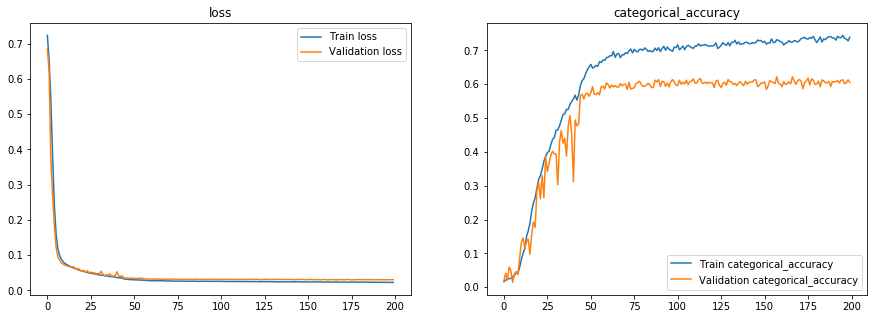

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history["loss"], label="Train loss")
ax[0].plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
ax[1].set_title('categorical_accuracy')
ax[1].plot(hist.epoch, hist.history["categorical_accuracy"], label="Train categorical_accuracy")
ax[1].plot(hist.epoch, hist.history["val_categorical_accuracy"], label="Validation categorical_accuracy")
ax[0].legend()
ax[1].legend()

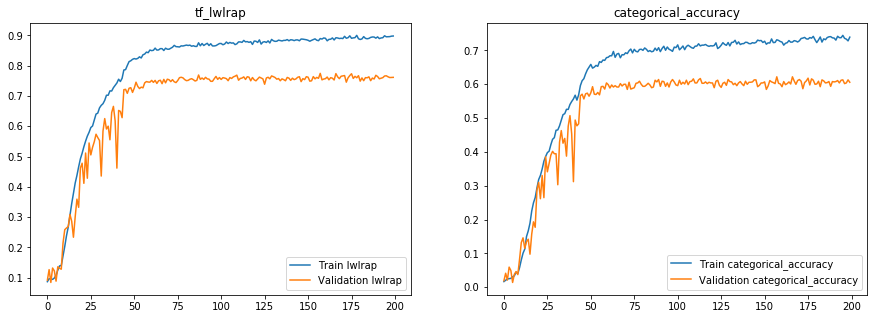

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('tf_lwlrap')
ax[0].plot(hist.epoch, hist.history["tf_lwlrap"], label="Train lwlrap")
ax[0].plot(hist.epoch, hist.history["val_tf_lwlrap"], label="Validation lwlrap")
ax[1].set_title('categorical_accuracy')
ax[1].plot(hist.epoch, hist.history["categorical_accuracy"], label="Train categorical_accuracy")
ax[1].plot(hist.epoch, hist.history["val_categorical_accuracy"], label="Validation categorical_accuracy")
ax[0].legend()
ax[1].legend()

In [31]:
model.load_weights(checkpoint_file)

# Calculate Validation Score using TTA
Note that we have to initiate validation_generation everytime before doing a new prediction as `model.fit_generator` will mis-index examples at the end of epoch (and you will get random score)

In [32]:
validation_generator = FATTrainDataset.create_generator(
    x_val, y_val, BATCH_SIZE, (SIZE,SIZE,3), augument=False, shuffling=False)

pred_val_y = model.predict_generator(validation_generator,steps=val_steps,verbose=1)
for ii in range(TTA):
    validation_generator = FATTrainDataset.create_generator(
        x_val, y_val, BATCH_SIZE, (SIZE,SIZE,3), augument=False, shuffling=False)

    pred_val_y += model.predict_generator(validation_generator,steps=val_steps,verbose=1)

'''Since the score is based on ranking, we do not need to normalize the prediction'''
# pred_val_y = pred_val_y/10


16/16 [==============================] - 1s 52ms/step


'Since the score is based on ranking, we do not need to normalize the prediction'

In [33]:
train_generator = FATTrainDataset.create_generator(
    x_trn, y_trn, BATCH_SIZE, (SIZE,SIZE,3), augument=True, shuffling=False)
pred_train_y = model.predict_generator(train_generator,steps=train_steps,verbose=1)

63/63 [==============================] - 5s 86ms/step


In [34]:
import sklearn.metrics
def calculate_overall_lwlrap_sklearn(truth, scores):
    """Calculate the overall lwlrap using sklearn.metrics.lrap."""
    # sklearn doesn't correctly apply weighting to samples with no labels, so just skip them.
    sample_weight = np.sum(truth > 0, axis=1)
    nonzero_weight_sample_indices = np.flatnonzero(sample_weight > 0)
    overall_lwlrap = sklearn.metrics.label_ranking_average_precision_score(
      truth[nonzero_weight_sample_indices, :] > 0, 
      scores[nonzero_weight_sample_indices, :], 
      sample_weight=sample_weight[nonzero_weight_sample_indices])
    return overall_lwlrap

In [35]:
print(pred_val_y.shape, y_val.shape)
print(np.sum(pred_val_y), np.sum(y_val))
# for ii in range(len(y_val)):
#     print(np.sum(pred_val_y[ii]), np.sum(y_val[ii]))

(994, 80) (994, 80)
-11021101.0 1128


In [36]:
print("lwlrap from sklearn.metrics for training data =", calculate_overall_lwlrap_sklearn(y_trn, pred_train_y))
print("lwlrap from sklearn.metrics =", calculate_overall_lwlrap_sklearn(y_val, pred_val_y/10))

score, weight = calculate_per_class_lwlrap(y_val, pred_val_y)
lwlrap = (score * weight).sum()
print('direct calculation of lwlrap : %.4f' % (lwlrap))

lwlrap from sklearn.metrics for training data = 0.8982367200698727
lwlrap from sklearn.metrics = 0.7674129591683412
direct calculation of lwlrap : 0.7674


## Predict Test Data with TTA

In [37]:
test_steps = np.ceil(float(len(x_test)) / float(BATCH_SIZE)).astype(int)


In [38]:
test_generator = FATTrainDataset.create_generator(
    x_test, x_test, BATCH_SIZE, (SIZE,SIZE,3), augument=False, shuffling=False, test_data=True)
pred_test_y = model.predict_generator(test_generator,steps=test_steps,verbose=1)

for ii in range(TTA):
    test_generator = FATTrainDataset.create_generator(
        x_test, x_test, BATCH_SIZE, (SIZE,SIZE,3), augument=False, shuffling=False, test_data=True)
    pred_test_y += model.predict_generator(test_generator,steps=test_steps,verbose=1)

18/18 [==============================] - 1s 51ms/step


In [39]:
sort_idx = np.argsort(labels).astype(int)


In [40]:
print(sort_idx)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79]


In [41]:
sample_sub = pd.read_csv('../input/freesound-audio-tagging-2019/sample_submission.csv')
test_Y_sort = pred_test_y[:, sort_idx]
sample_sub.iloc[:, 1:] =  test_Y_sort
sample_sub.to_csv('submission.csv', index=False)

sample_sub.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,Bus,Buzz,Car_passing_by,Cheering,Chewing_and_mastication,Child_speech_and_kid_speaking,Chink_and_clink,Chirp_and_tweet,Church_bell,Clapping,Computer_keyboard,Crackle,Cricket,Crowd,Cupboard_open_or_close,Cutlery_and_silverware,Dishes_and_pots_and_pans,Drawer_open_or_close,Drip,Electric_guitar,Fart,Female_singing,Female_speech_and_woman_speaking,Fill_(with_liquid),Finger_snapping,Frying_(food),Gasp,Glockenspiel,Gong,...,Harmonica,Hi-hat,Hiss,Keys_jangling,Knock,Male_singing,Male_speech_and_man_speaking,Marimba_and_xylophone,Mechanical_fan,Meow,Microwave_oven,Motorcycle,Printer,Purr,Race_car_and_auto_racing,Raindrop,Run,Scissors,Screaming,Shatter,Sigh,Sink_(filling_or_washing),Skateboard,Slam,Sneeze,Squeak,Stream,Strum,Tap,Tick-tock,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,000ccb97.wav,-163.326508,-127.003296,-137.344559,-126.169853,-137.099304,-95.876122,-125.664711,-93.716568,-94.703079,-117.377510,-161.496063,-98.254410,-152.936798,-142.869904,-89.124245,-99.089035,-105.199852,-110.813637,-167.253296,-42.053936,-104.919930,-81.890091,-130.427719,-136.445480,-137.156357,-116.864670,-120.403427,-126.764648,-66.019295,-141.303726,-120.348221,-127.865952,-105.840103,-118.780632,-14.004517,-86.674942,-108.778221,-127.958794,-132.544281,...,-130.467819,-78.922585,-77.917694,-91.279961,-141.727310,-118.924675,-85.351357,-120.401955,-125.245354,-107.770271,-115.064507,-169.613007,-120.200035,-145.572006,-156.387314,-60.218742,-85.626663,-33.501293,-131.553207,-87.123055,-137.464890,-123.029312,-105.667885,-132.421097,-102.913704,-145.964478,-106.900627,-136.116959,-54.010841,-100.404701,-124.644936,-148.530762,-117.328918,-83.242477,-103.725266,-126.237343,-88.915764,-82.690109,-123.331154,-130.141586
1,0012633b.wav,-61.516827,-137.957840,-135.251022,-131.443039,-143.504868,-91.525894,-95.100571,-71.105103,-143.161514,-134.524475,-120.346870,-46.736603,-105.836449,-164.404800,-83.155899,-101.337639,-154.266937,-139.005035,-129.626755,-124.227310,-142.726013,-101.476654,-115.320572,-149.794159,-103.935867,-149.656647,-163.327408,-94.886772,-136.855560,-119.211861,-101.089973,-105.599289,-107.653961,-120.390030,-140.153824,-67.572388,-139.666107,-158.461807,-122.430939,...,-96.537735,-122.251701,-84.801971,-141.487045,-181.586334,-99.657234,-107.053207,-170.472198,-115.240723,-121.427605,-117.045731,-47.767025,-116.433083,-111.015984,-117.057663,-143.644608,-99.069374,-115.339142,-141.811096,-128.247726,-93.803818,-86.983429,-134.433380,-110.397751,-112.155441,-106.202179,-99.703026,-132.421921,-138.517380,-135.493912,-96.295563,-105.209061,-118.531754,-79.120201,-87.881973,-76.267761,-135.798553,-119.258621,-126.908409,-79.048164
2,001ed5f1.wav,-143.204468,-116.359268,-171.419418,-145.565826,-162.699585,-104.440559,-178.680817,-115.201103,-144.318588,-181.171890,-124.767670,-174.423737,-126.619141,-142.114166,-105.237106,-167.072876,-171.083618,-172.794205,-159.526276,-75.499252,-73.489700,-120.534035,-194.184784,-144.941940,-121.444344,-144.566086,-144.912659,-56.960598,-171.115433,-120.010994,-98.426331,-194.418823,-130.729202,-165.935928,-153.662247,-154.682068,-165.994873,-177.782669,-167.611755,...,-162.111710,-158.757675,-139.856384,-135.677750,-63.248131,-141.793274,-117.006775,-168.491684,-178.772995,-143.459732,-71.699127,-134.442291,-145.045731,-176.854324,-144.462540,-156.713089,-19.328241,-97.318512,-191.861496,-119.050102,-157.246490,-155.709457,-63.515446,-42.678654,-91.052040,-71.286865,-133.747314,-167.629395,-74.598259,-126.484406,-153.946716,-139.543411,-164.702148,-41.436291,-142.089691,-122.757385,-138.646347,-103.461441,-146.732437,-87.085861
3,00294be0.wav,-160.268265,-215.082672,-203.810699,-220.746155,-186.949509,-198.693512,